<a href="https://colab.research.google.com/github/hvr2026/Decision-trees/blob/main/Decision%20Trees/Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

In [2]:
# Define Gini Impurity function
def giniImpurity(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return np.sum(ps * (1 - ps))

# Define Node class for Decision Tree
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [3]:
# Define custom Decision Tree class
class DecisionTree:
    def __init__(self, min_samples_split=5, max_depth=100):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split:
            return Node(value=self._most_common_label(y))

        feat_idxs = np.arange(n_features)
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)

        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._gini_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold
        return split_idx, split_thresh

    def _gini_gain(self, y, X_column, split_thresh):
        parent_gini = giniImpurity(y)
        left_idxs, right_idxs = self._split(X_column, split_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        g_l, g_r = giniImpurity(y[left_idxs]), giniImpurity(y[right_idxs])
        child_gini = (n_l / n) * g_l + (n_r / n) * g_r
        return parent_gini - child_gini

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _most_common_label(self, y):
        counter = Counter(y)
        return counter.most_common(1)[0][0]

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

In [4]:
# Load the dataset
diabetes_data = pd.read_csv('/content/diabetes.csv')


In [5]:
# Separate features and target
X = diabetes_data.drop(columns=["PatientID", "Diabetic"]).values
y = diabetes_data["Diabetic"].values

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [7]:
# Train the Decision Tree
dec_tree = DecisionTree(max_depth=10, min_samples_split=5)
dec_tree.fit(X_train, y_train)


In [8]:
# Predict on test set
y_test_pred = dec_tree.predict(X_test)

# Evaluate performance
accuracy = np.mean(y_test_pred == y_test)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.91
Precision: 0.87
Recall: 0.85
F1 Score: 0.86


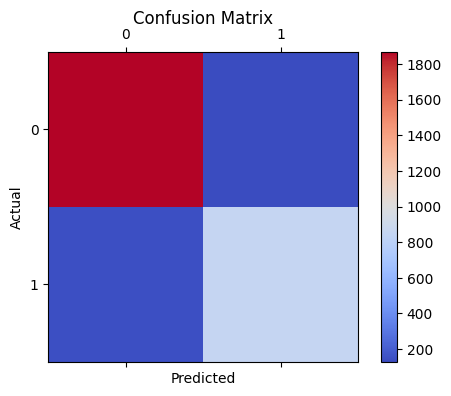

In [9]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
plt.matshow(conf_matrix, cmap="coolwarm", fignum=1)
plt.title("Confusion Matrix", pad=20)
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

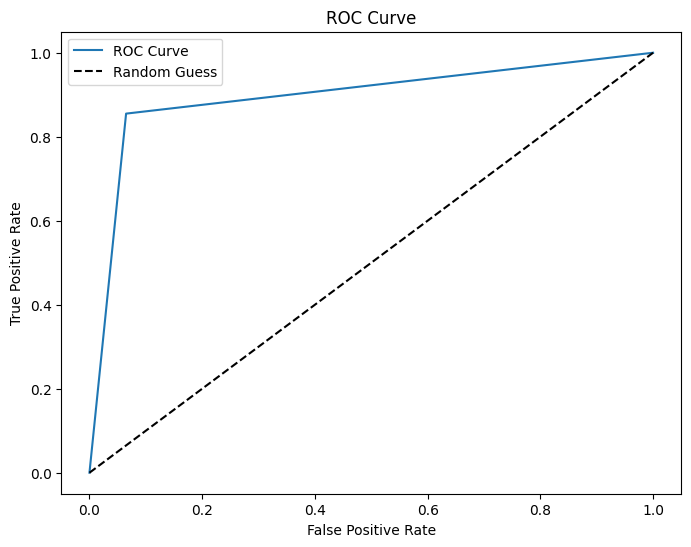

In [10]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


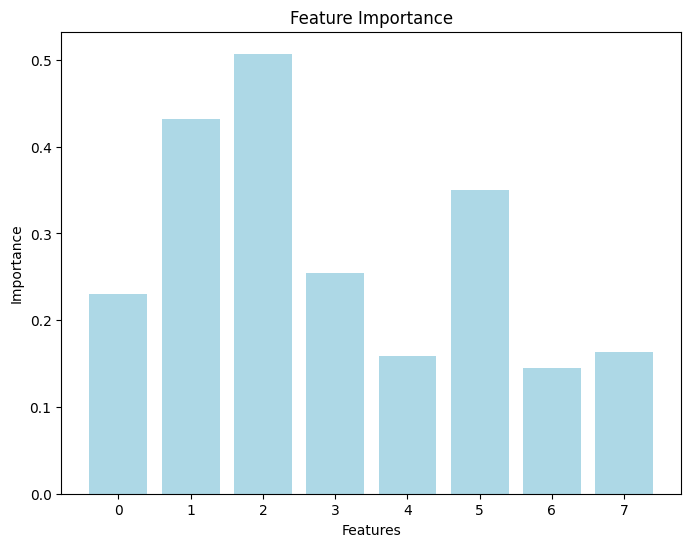

In [11]:
# Feature Importance (custom decision tree does not support this natively)
feature_importance = np.abs(X_train.mean(axis=0))
plt.figure(figsize=(8, 6))
plt.bar(range(len(feature_importance)), feature_importance, color="lightblue")
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

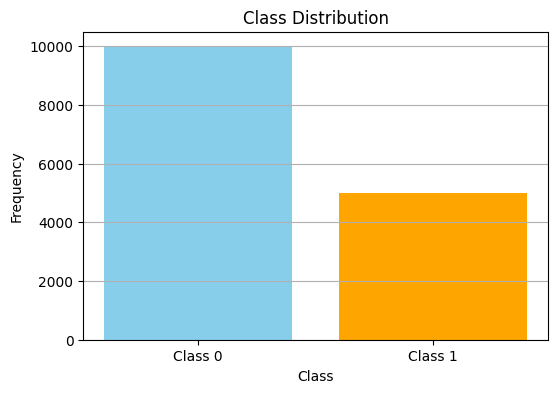

In [12]:
# 1. Class Distribution
plt.figure(figsize=(6, 4))
plt.bar(["Class 0", "Class 1"], np.bincount(y), color=["skyblue", "orange"])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.grid(axis="y")
plt.show()

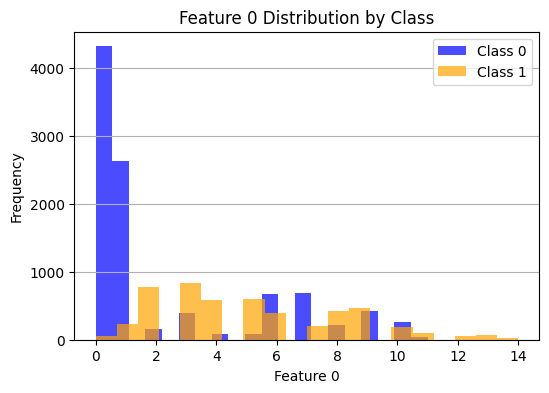

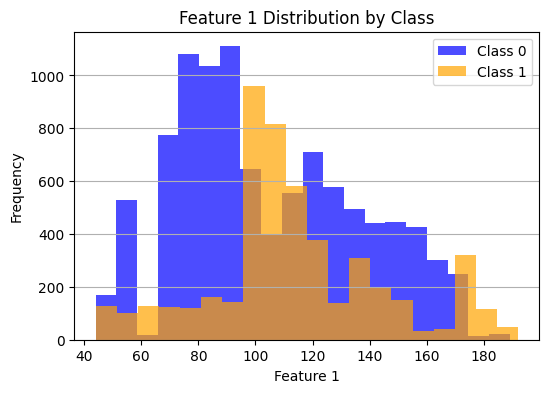

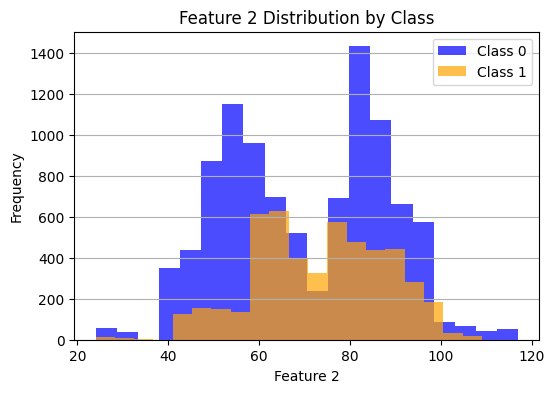

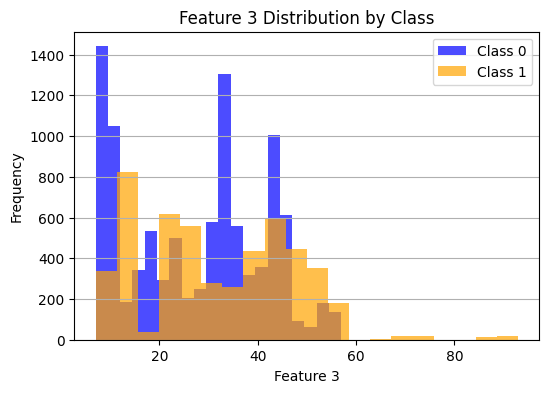

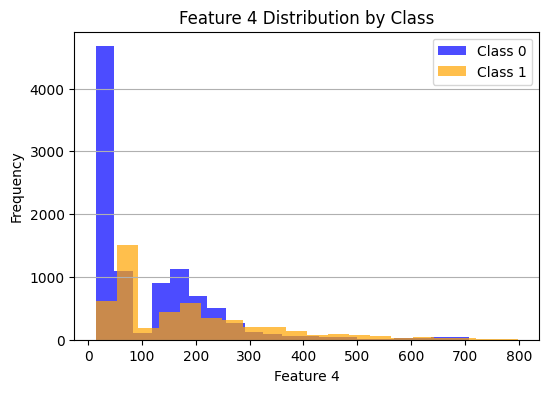

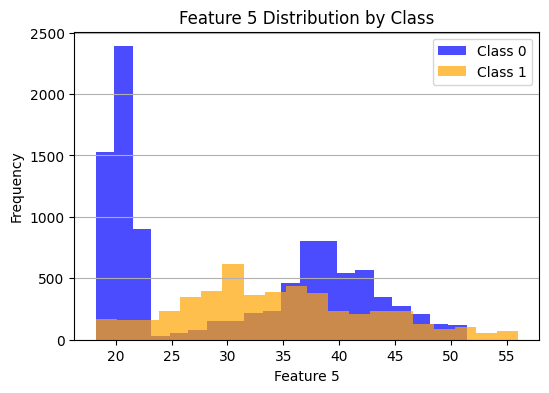

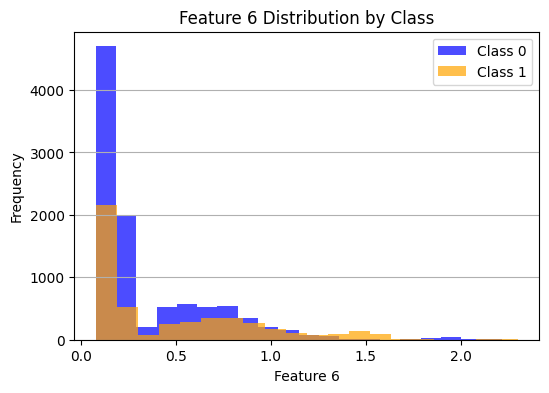

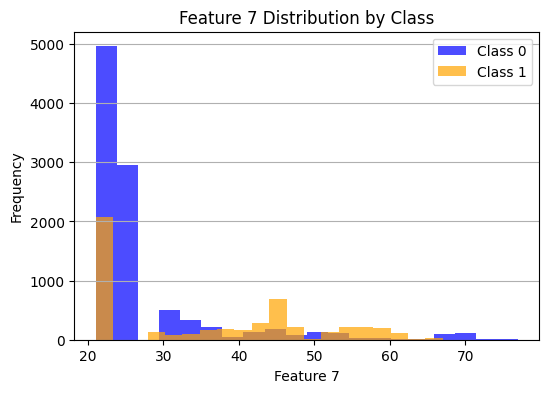

In [18]:
#  Feature Distributions by Class
num_features = X.shape[1]
for i in range(num_features):
    plt.figure(figsize=(6, 4))
    plt.hist(X[y == 0, i], bins=20, alpha=0.7, label="Class 0", color="blue")
    plt.hist(X[y == 1, i], bins=20, alpha=0.7, label="Class 1", color="orange")
    plt.title(f"Feature {i} Distribution by Class")
    plt.xlabel(f"Feature {i}")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(axis="y")
    plt.show()

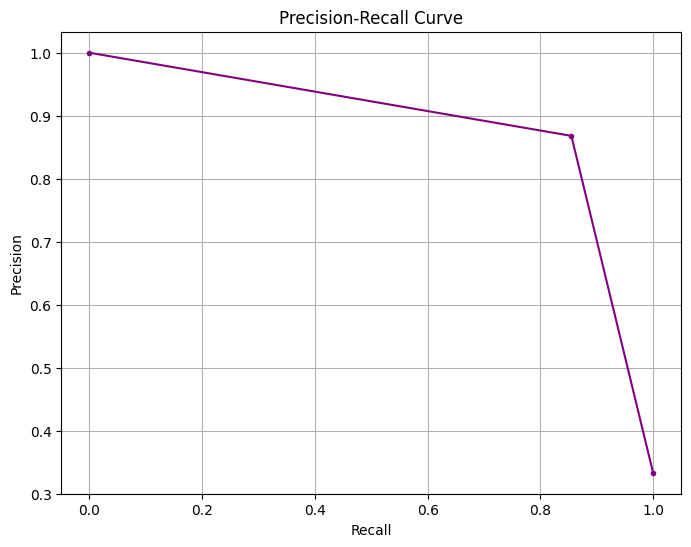

In [19]:
#  Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='purple')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()


In [20]:
#  Cumulative Gain Chart
def plot_cumulative_gain(y_true, y_pred):
    sorted_indices = np.argsort(y_pred)[::-1]
    y_sorted = y_true[sorted_indices]
    cumulative = np.cumsum(y_sorted) / y_sorted.sum()
    cumulative_baseline = np.linspace(0, 1, len(cumulative))

    plt.figure(figsize=(8, 6))
    plt.plot(cumulative, label="Model", color="green")
    plt.plot(cumulative_baseline, label="Baseline", color="red", linestyle="--")
    plt.title("Cumulative Gain Chart")
    plt.xlabel("Samples")
    plt.ylabel("Cumulative Gains")
    plt.legend()
    plt.grid()
    plt.show()

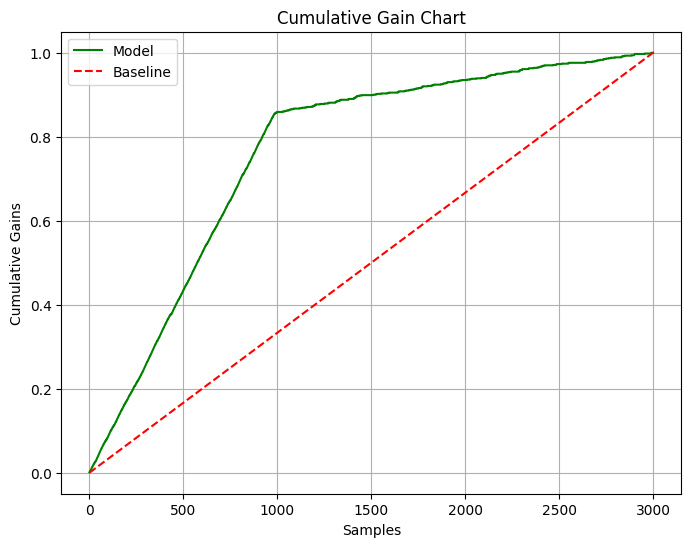

In [21]:
# Generate predictions probabilities (For simplicity, use binary values in this custom tree)
plot_cumulative_gain(y_test, y_test_pred)